## Makemore 2

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available

In [2]:
words = open("names.txt", "r").read().splitlines() # Python list of strings
print(words[:8]) # show a sample of the first 8 names
print(len(words)) # this many words in total

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


In [3]:
# build a vocabulary of characters map them to integers
chars = sorted(list(set(''.join(words)))) # set(): Throwing out letter duplicates

stoi = {s:i+1 for i,s in enumerate(chars)} # Make tupels of type (char, counter)
stoi['.'] = 0 # Add this special symbol's entry explicitly

itos = {i:s for s,i in stoi.items()} # Switch order of (char, counter) to (counter, char)

# showing the two mappings, they really just are mirrors of one another
print(itos)
print()
print(stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [6]:
# Build the dataset
block_size = 3  # context length: how many characters used to predict the next? (1 before)
X, Y = [], []   # features (input) and labels (output)

# Just showing off the first five words split into tokens
for w in words[:5]:
    print(f'\n{w}')
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # Showing what input and expected output now look like
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append, like a sliding window; NEAT!
        # old context starts at index 1 and is appended with the new index -> sliding window of block_size

# Again, these *do not* carry characters, but their respective indexes
X = torch.tensor(X)
Y = torch.tensor(Y)


emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .

olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .

ava
... ---> a
..a ---> v
.av ---> a
ava ---> .

isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .

sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [7]:
# This is what the dataset looks like right now
print(f'Input:  {X.shape}\t{X.dtype}\t{X[0]}') # 32 times the 3 character indexes before the next one
print(f'Output: {Y.shape}\t{Y.dtype}\t{Y[0]}') # 32 times the next character's index

Input:  torch.Size([32, 3])	torch.int64	tensor([0, 0, 0])
Output: torch.Size([32])	torch.int64	5


In [8]:
# This will be the lookup table
C = torch.randn((27, 2)) # each of 27 items has its own unique 2-dimensional numeric embedding in here
print(C)

tensor([[-0.3548, -0.5329],
        [ 0.2653,  0.7427],
        [ 1.7673,  0.6609],
        [ 1.3003, -0.7154],
        [ 1.2715,  0.5188],
        [-1.4614, -1.1937],
        [ 0.1986, -0.2185],
        [ 1.3562,  0.3410],
        [-0.7048,  1.3111],
        [-0.4812,  1.3220],
        [-0.2868,  2.0298],
        [ 1.2546, -0.9407],
        [-0.3204,  2.4479],
        [ 0.5627, -0.7491],
        [-0.4169, -0.7734],
        [ 0.4668, -0.1372],
        [ 0.6961,  1.9624],
        [-0.1492,  0.3179],
        [ 1.0576,  0.5193],
        [-0.7136,  1.1199],
        [-1.5970, -0.2079],
        [-0.4926, -2.0621],
        [ 0.8042,  0.8158],
        [ 0.0097,  1.7124],
        [-0.0599,  0.0653],
        [ 1.5450,  0.7888],
        [-0.8725,  0.3949]])


In [9]:
print(C[stoi['e']])

tensor([-1.4614, -1.1937])


In [10]:
# Given 27 possible characters, embed the number 5 (e)
F.one_hot(torch.tensor(5), num_classes=27) # shape is (27,)

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

In [11]:
print(F.one_hot(torch.tensor(stoi['e']), num_classes=27).float() @ C) # stoi['e'] = 5
print(F.one_hot(torch.tensor(stoi['e']), num_classes=27).float() @ C == C[stoi['e']])

tensor([-1.4614, -1.1937])
tensor([True, True])


In [12]:
print(X[13, 2])   # Plugging out an example character, here 'a' from ..a ---> v (14th input, 3rd character)
print(C[X][13,2]) # This construct actually returns the 2-dim. embedding vector for 'a'

# For all embeddings (character index to 2D vector) at once, Python can do this:
emb = C[X] # Done!

print(C[X].shape) # 32 times 3 times 2 -> 32 inputs, 3 characters each, 2 dimensional embedding vector each

tensor(1)
tensor([0.2653, 0.7427])
torch.Size([32, 3, 2])


In [13]:
W1 = torch.randn((6, 100)) # 6 -> 3 vectors á 2 values, 100 neurons
b1 = torch.randn(100)      # for each of the 100 neurons, add a bias

In [14]:
# 32 vectors, one for each input tuple, each 6-dimensional (3 characters, 2 values each)
emb[:, 0, :] # This is the first character's embedding vector for all 32 input tuples

print(emb[:, 0, :].shape) # 32 times 2 -> 32 inputs, 2 values each

torch.Size([32, 2])


In [15]:
# Concatenating all three input character embedding vectors into one 6-dimensional vector per input tuple
# 1 means: Concatenate along the first dimension (rows) -> 32 times 6
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1)
print(torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]], 1).shape)

torch.Size([32, 6])


In [16]:
# We separate the 32x3x2 into a tuple of 3 individual 32x2 tensors using unbind()
# 1 -> dimension 1 is the axis along a tuple of (therefore 3) tensors is created, each 32x2 (the other two dimensions)
print(torch.unbind(emb, 1)[0].shape) # This is equivalient to the above list [emb[:,0,:], emb[:,1,:], emb[:,2,:]]
print(len(torch.unbind(emb, 1)))

torch.Size([32, 2])
3


In [17]:
# We concatenate the three 32x2 tensors into one big tensor, just like before
torch.cat(torch.unbind(emb, 1), 1) # concatenate all (3 here) individual 32x2 tensors along dimension 1 (a row is 3 2-dimensional vectors each -> 6-dimensional vector now)
print(torch.cat(torch.unbind(emb, 1), 1).shape) # 32 times 6

torch.Size([32, 6])


In [18]:
a = torch.arange(18)
print(a.shape) # 18-dimensional vector

# Reshape to 3x3x2 tensor (works, as 3x3x2 = 18) (very efficient, no copying of data)
a = a.view(3, 3, 2)
print(a.shape)

# Can we transfer this approach to our 32x3x2 tensor problem?
True if torch.all(torch.eq(emb.view(32, 6), torch.cat(torch.unbind(emb, 1), 1))) else False
# Long story short: Yes, we can! All of the above is equivalent to just re-arranging how we look at the data

torch.Size([18])
torch.Size([3, 3, 2])


True

In [19]:
# h is the result of the hidden layer
# h = emb.view(emb.shape[0],6) @ W1 + b1 # emb.shape[0] is 32, but this has to be variable (BUG!)

# Alternative to the above comment, again because of PyTorch:
# PyTorch reads the -1 and infers, because 6 is already used up from (2x3): 32 times 6 or inputs times 6 generally
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # produces 32 times 100 activations of the hidden layer

# Just for fun, let's see what h and its contents look like
print(h.shape)
print(h[0][:5])

torch.Size([32, 100])
tensor([ 0.9889,  0.7468,  0.0723, -0.2582, -0.7088])


In [20]:
print((emb.view(-1,6) @ W1).shape)
print(b1.shape)

torch.Size([32, 100])
torch.Size([100])


In [21]:
# Initialize weights and biases for the output layer randomly
W2 = torch.randn((100, 27)) # 100 inputs, 27 output neurons
b2 = torch.randn(27)        # 27 biases

# Neuron outputs
logits = h @ W2 + b2
print('Logits:', logits.shape) # This should be 32 times 27

# Softmax transforms outputs into probabilities
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
print('Probabilities:', prob.shape) # This should be 32 times 27 still

Logits: torch.Size([32, 27])
Probabilities: torch.Size([32, 27])


In [22]:
Y[0] # This is the first expected output, the index of the first character in the first word

tensor(5)

In [23]:
# For each of the 32 input triplets, give the probability for the correct output neuron, which itself is accessed at the index stored in Y at the same position
print(prob[torch.arange(32), Y])
print(prob[torch.arange(32), Y].shape) # 32 probabilities, one for each input triplet

tensor([4.4535e-04, 6.3597e-08, 1.3995e-10, 6.0824e-10, 3.6398e-08, 4.2817e-01,
        4.2669e-07, 1.0000e+00, 6.6640e-12, 1.2813e-12, 2.5222e-10, 1.7880e-03,
        6.1291e-06, 2.4717e-04, 9.0564e-14, 1.6517e-04, 8.4807e-04, 1.7573e-10,
        8.5900e-14, 3.9842e-09, 6.4860e-04, 2.1414e-06, 4.0577e-12, 2.5571e-12,
        1.1691e-04, 3.3432e-10, 4.1580e-10, 1.9952e-08, 2.6286e-07, 7.9872e-04,
        2.3098e-11, 3.6606e-04])
torch.Size([32])


In [24]:
# We want the average log proability over all 32 inputs to be our loss
loss = -prob[torch.arange(32), Y].log().mean()
print(loss.item()) # This is to be minimized

16.206439971923828


In [25]:
print('X:', X.shape, ' Y:', Y.shape)

# Let's re-initialize the weights and biases
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)        # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)      # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)        # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)     # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)         # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # print the total number of parameters (nelements = number of elements) present in the tensors

X: torch.Size([32, 3])  Y: torch.Size([32])
3481 parameters


In [26]:
# Allowing for gradient accumulation
for p in parameters:
    p.requires_grad = True

In [27]:
# 1000 training steps (epochs)
for _ in range(1000):
    # Forward-Pass
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    
    # Replacing the above lines with PyTorch's built-in cross entropy loss function:
    # this function behaves better numerically and avoids pitfalls like infinities by subtracting the maximum value from all logits before exponentiating
    loss = F.cross_entropy(logits, Y)

    # Backward-Pass
    for p in parameters:
        p.grad = None # Reset gradients (done before each backward pass to avoid accumulation over multiple passes)
    
    loss.backward()
    
    # Update
    for p in parameters:
        p.data += -0.1 * p.grad # Nudge parameter values in negative gradient direction (learning rate = 0.1)

print(loss.item())

0.2561509907245636


In [28]:
print(logits.max(1)) # For each of the 32 inputs, give the index of the highest probability output neuron
print(f'\n{Y}')

torch.return_types.max(
values=tensor([13.3437, 17.7879, 20.5832, 20.6042, 16.7390, 13.3437, 15.9747, 14.1889,
        15.9158, 18.3894, 15.9409, 20.9284, 13.3437, 17.1212, 17.1498, 20.0637,
        13.3437, 16.4564, 15.1328, 17.0537, 18.5905, 15.9655, 10.8739, 10.6874,
        15.5062, 13.3437, 16.2394, 16.9563, 12.7426, 16.2141, 19.0840, 16.0213],
       grad_fn=<MaxBackward0>),
indices=tensor([ 9, 13, 13,  1,  0,  9, 12,  9, 22,  9,  1,  0,  9, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0,  9, 15, 16,  8,  9,  1,  0]))

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])


In [29]:
# Build the dataset
block_size = 3  # context length: how many characters used to predict the next? (1 before)
X, Y = [], []   # features (input) and labels (output)

# Just show the first three words as example
for w in words:
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        
        X.append(context)
        Y.append(ix)
        
        # Showing what input and expected output now look like
        context = context[1:] + [ix] # crop and append, like a rolling window; NEAT!

# These DO NOT carry characters, but their respective index numbers
X = torch.tensor(X)
Y = torch.tensor(Y)

print('Input:', X.shape, X.dtype, X[0])
print('Output:', Y.shape, Y.dtype, Y[0]) 

Input: torch.Size([228146, 3]) torch.int64 tensor([0, 0, 0])
Output: torch.Size([228146]) torch.int64 tensor(5)


In [30]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)        # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters') # Network stays the same, so same number of parameters

3481 parameters


In [31]:
# Allowing for gradient accumulation
for p in parameters:
    p.requires_grad = True

In [32]:
for _ in range(10):
    # Forward-Pass
    emb = C[X] # (228146, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (228146, 100)
    logits = h @ W2 + b2 # (228146, 27)

    # Leaving this here for happy memories of low performance:
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdims=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    
    loss = F.cross_entropy(logits, Y)
    
    print(loss.item())
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # Update
    for p in parameters:
        p.data += -0.1 * p.grad

19.505229949951172
17.0844783782959
15.776531219482422
14.833342552185059
14.002608299255371
13.253264427185059
12.57992172241211
11.98310375213623
11.470495223999023
11.051856994628906


In [33]:
print(torch.randint(0, X.shape[0], (32,))) # Construct a tensor of 32 randomly drawn numbers between 0 and 228146

tensor([ 73461,  29523, 187839,  61098,  14518,  18832,  93953, 117166,   1351,
        134694, 185918,  43887,  75818,  83151,  38470,  20884,  23529,   1400,
         44105, 224530, 182414, 216199,  98331, 100987, 189983, 129885,  58689,
        205549,  96468,  65615, 164013,  49263])


In [34]:
# Reset the parameters once again for this new approach
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)        # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters') # Network stays the same, so same number of parameters

for p in parameters:
    p.requires_grad = True

3481 parameters


In [35]:
for _ in range(1000):
    
    # mini-batch construction -> 32 indices of 3-dimensional character index vectors within X
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward-Pass
    emb = C[X[ix]] # (32, 3, 2), a single batch, X[ix] grabs only the 32 indices, C then grabs the 2-dimensional vectors for each of the 3 characters for the current of the 32 triplets
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y[ix]) # Y[ix] grabs the 32 expected output indices for the current batch (very elegant)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    # Update
    for p in parameters:
        p.data += -0.1 * p.grad

print('Loss for current mini-batch:', loss.item())

Loss for current mini-batch: 2.6383352279663086


In [36]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print('Loss for entire dataset:', loss.item())

Loss for entire dataset: 2.6822779178619385


In [37]:
lre = torch.linspace(-3, 0, 1000) # 1000 values between -3 and 0, linearly spaced
lrs = 10 ** lre # 1000 values between 10^-3 and 10^0

In [38]:
# Reset the parameters once again
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)        # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

for p in parameters:
    p.requires_grad = True

lri = []   # List of applied learning rates
lossi = [] # List of resulting losses for each learning rate respectively

for i in range(1000):
    # mini-batch construction
    ix = torch.randint(0, X.shape[0], (32,)) # (32,)
    
    # Forward-Pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)

    loss = F.cross_entropy(logits, Y[ix])
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Set learning rate candidate
    lr = lrs[i]
    
    for p in parameters:
        p.data += -lr * p.grad
    
    # Tracking stats
    lri.append(lr)
    lossi.append(loss.item())
    
# print('Loss for current mini-batch:', loss.item())

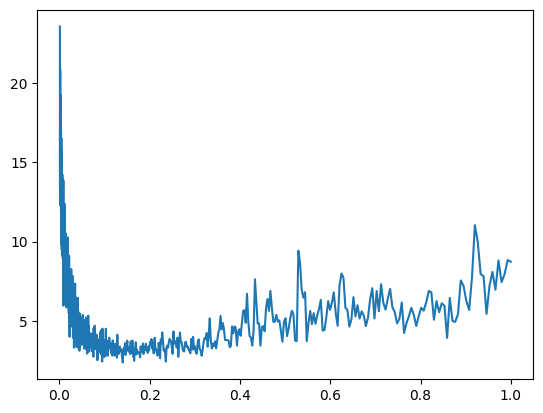

In [39]:
plt.plot(lri, lossi);

In [40]:
# Get index of smallest loss in lossi
print(lri[lossi.index(min(lossi))])

tensor(0.1403)


In [41]:
# Reset the parameters once again
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)        # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

for p in parameters:
    p.requires_grad = True

In [42]:
for i in range(70000):
    
    # mini-batch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # Forward-Pass
    emb = C[X[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Learning rate decay to more closely approach the minimum
    lr = 0.1 if i < 50000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad
    
# print('Loss for current mini-batch:', loss.item())

In [43]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)
print(loss.item())

2.302616834640503


In [44]:
import random

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print('X:', X.shape, '\tY:', Y.shape)
    return X,Y

random.seed(42)          # for reproducibility
random.shuffle(words)    # words is just the bare list of all names, from wayyy above
n1 = int(0.8*len(words)) # index at 80% of all words (rounded for integer indexing)
n2 = int(0.9*len(words)) # index at 90% of all words (rounded for integer indexing)

print('Training Set:')
Xtr, Ytr = build_dataset(words[:n1])     # The first 80% of all words
print('Validation Set:')
Xdev, Ydev = build_dataset(words[n1:n2]) # The 10% from 80% to 90% of all words
print('Test Set:')
Xte, Yte = build_dataset(words[n2:])     # The 10% from 90% to 100% of all words

Training Set:
X: torch.Size([182625, 3]) 	Y: torch.Size([182625])
Validation Set:
X: torch.Size([22655, 3]) 	Y: torch.Size([22655])
Test Set:
X: torch.Size([22866, 3]) 	Y: torch.Size([22866])


In [45]:
# Reset the parameters once again
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)          # 27 characters, 2 dimensions each
W1 = torch.randn((6,100), generator=g)        # 3 characters times 2 embedding values as inputs to 100 neurons
b1 = torch.randn((100), generator=g)          # 100 biases added to the 100 neuron outputs
W2 = torch.randn((100,27), generator=g)       # 100 neuron outputs as inputs to 27 output neurons
b2 = torch.randn((27), generator=g)           # 27 biases added to the 27 output neurons

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True

3481 parameters


In [46]:
for i in range(40000):
    
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Learning rate decay to more closely approach the minimum
    lr = 0.1 if i < 30000 else 0.01

    for p in parameters:
        p.data += -lr * p.grad
    
# print('Loss for current mini-batch:', loss.item())

In [47]:
# Validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.332082509994507


In [48]:
# Test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.33383846282959


In [49]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6,300), generator=g)
b1 = torch.randn((300), generator=g)
W2 = torch.randn((300,27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True

10281 parameters


In [50]:
lossi = [] # list of losses per mini-batch
stepi = [] # list of steps (mini-batches)

for i in range(180000):
    
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) 
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    
    loss.backward()
    
    lr = 0.1 if i < 60000 else 0.05 if i < 120000 else 0.01
    
    for p in parameters:
        p.data += -lr * p.grad
    
    # Loss per mini-batch tracking
    stepi.append(i)
    lossi.append(loss.item())
    
#print('Loss for current mini-batch:', loss.item())

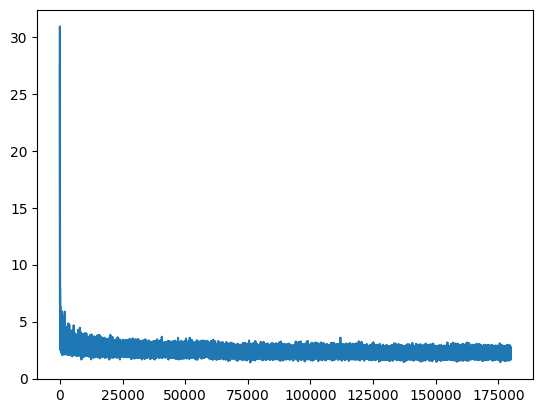

In [51]:
plt.plot(stepi, lossi);

In [52]:
# Training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.2399778366088867


In [53]:
# Validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.247354745864868


In [54]:
# Test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.250739097595215


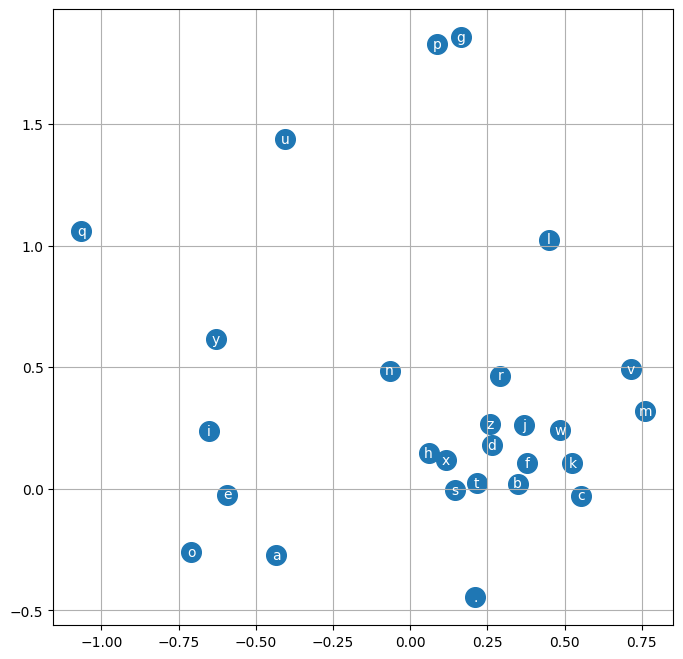

In [55]:
# This code plots the 2-dimensional embeddings of the 27 characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [56]:
import tqdm
import random

In [57]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print('X:', X.shape, '\tY:', Y.shape)
    return X,Y

random.seed(42)          # for reproducibility
random.shuffle(words)    # words is just the bare list of all names, from wayyy above
n1 = int(0.8*len(words)) # index at 80% of all words (rounded for integer indexing)
n2 = int(0.9*len(words)) # index at 90% of all words (rounded for integer indexing)

print('Training Set:')
Xtr, Ytr = build_dataset(words[:n1])     # The first 80% of all words
print('Validation Set:')
Xdev, Ydev = build_dataset(words[n1:n2]) # The 10% from 80% to 90% of all words
print('Test Set:')
Xte, Yte = build_dataset(words[n2:])     # The 10% from 90% to 100% of all words


Training Set:
X: torch.Size([182580, 3]) 	Y: torch.Size([182580])
Validation Set:
X: torch.Size([22767, 3]) 	Y: torch.Size([22767])
Test Set:
X: torch.Size([22799, 3]) 	Y: torch.Size([22799])


In [58]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn((200), generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn((27), generator=g)

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure

print(sum(p.nelement() for p in parameters), 'parameters')

for p in parameters:
    p.requires_grad = True
    
lossi = []
stepi = []

11897 parameters


In [59]:
for i in tqdm.tqdm(range(300000)):
    # mini-batch construct
    ix = torch.randint(0, Xtr.shape[0], (128,)) # Batch size was 32 before, now 128
    
    # Forward-Pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h1 = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 300)
    logits = h1 @ W2 + b2 # (32, 50)
    loss = F.cross_entropy(logits, Ytr[ix]) # (32,)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 60000 else 0.05 if i < 120000 else 0.01
    
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())
    
# print('Loss for current mini-batch:', loss.item())

100%|██████████| 300000/300000 [02:35<00:00, 1931.54it/s]


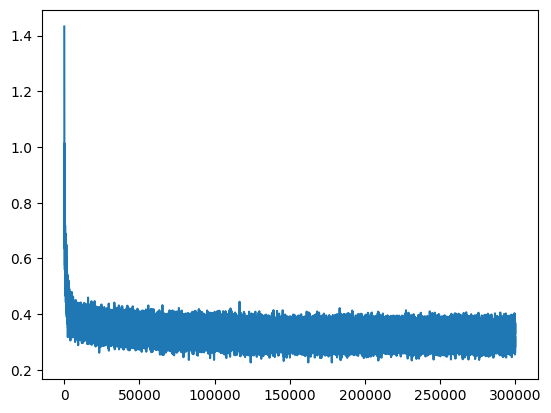

In [60]:
plt.plot(stepi, lossi);

In [61]:
# Validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1508326530456543


In [62]:
# Training loss
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # (32, 300)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.1210336685180664


In [63]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

mora.
kayah.
seel.
nduryah.
rethan.
endraege.
dered.
eliigh.
parelle.
elieananaraelynn.
hona.
cayshabergaviriel.
kindreelynn.
nophirius.
kyven.
kylene.
els.
kayshayveyah.
hal.
salynn.
